## Data Scientist - Take Home Task

__Author__: Fan Yuan  
__Created__: 09/08/2019

### Description:  
At the end of 2018, we conducted a survey of Duolingo users in 10 countries: Brazil, Colombia, Mexico, Germany, France, Great Britain, Russia, Japan, Taiwan, and the US. The survey asked users a series of demographic questions (e.g., employment status), as well as questions about behavior and motivation (e.g., primary reason for studying a language). The goal of this survey was to develop motivation-based user segments (or personas) to inform our future marketing efforts and product development.

### Data:
- User survey
- Usage data from Duolingo for users included in the survey  
_Note: Usage data was collected from September 1, 2018 to November 5, 2018. Note the data may require some reformatting or cleaning._

### Objectives:  
1)	Use quantitative methods to identify a set of user segments/personas  
2)	Explore the data to identify any actionable product or marketing insights


In [1]:
# Import packages needed in this project
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style="darkgrid")

# Pretty display for notebook
%matplotlib inline
from time import time

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA    

## Import the Data

In [2]:
# Import the survey data
survey = pd.read_csv('survey_data.csv')
survey.head()

,user_id,age,annual_income,country,duolingo_platform,duolingo_subscriber,duolingo_usage,employment_status,future_contact,gender,other_resources,primary_language_commitment,primary_language_review,primary_language_motivation,primary_language_motivation_followup,primary_language_proficiency,student,survey_complete,time_spent_seconds
0,35c9fc6e72c911e99681dca9049399ef,18-34,"$26,000 - $75,000",JP,Android phone or tablet,"No, I have never paid for Duolingo Plus",Daily,Employed full-time,Yes,Male,"Stories/novels/children's books,Movies/TV Shows",I'm very committed to learning this language.,I am using Duolingo to review a language I've ...,I like to learn new languages,"I want to learn as many languages as I can,Oth...",Advanced,Not currently a student,1,193
1,35c9fdde72c911e98630dca9049399ef,18-34,"$26,000 - $75,000",JP,iPhone or iPad,"No, I have never paid for Duolingo Plus",Weekly,Employed full-time,Yes,Male,NaN,I'm slightly committed to learning this language.,I am using Duolingo to review a language I've ...,I need to be able to speak the local language ...,"I am an immigrant,I am a refugee",Intermediate,Not currently a student,1,139
2,35c9feb072c911e9ab4cdca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,"Yes, I currently pay for Duolingo Plus",Daily,Employed full-time,Yes,Male,NaN,I'm moderately committed to learning this lang...,I am using Duolingo to review a language I've ...,I want to connect with my heritage or identity,NaN,Beginner,Not currently a student,1,119
3,35c9ff7072c911e9900ddca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,"No, but I have previously paid for Duolingo Plus",Daily,Employed full-time,Yes,Female,Other apps,I'm very committed to learning this language.,I am using Duolingo to learn this language for...,I am preparing for a trip,I want to learn some basics in the local langu...,Intermediate,Not currently a student,1,229
4,35ca002672c911e99effdca9049399ef,35 - 54,"$76,000 - $150,000",JP,Android phone or tablet,"Yes, I currently pay for Duolingo Plus",Daily,Employed full-time,Yes,Male,NaN,I'm very committed to learning this language.,I am using Duolingo to learn this language for...,I want to connect with my heritage or identity,NaN,Intermediate,Not currently a student,1,157


In [3]:
# Import the usage data
usage = pd.read_csv('app_usage_data.csv')
usage.head()

,user_id,duolingo_start_date,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
0,35cb7e8f72c911e9888edca9049399ef,6/20/18 21:14,NaN,46.0,True,False,277.0,88,741.0,668.0,135,137
1,35ca34fd72c911e99ed6dca9049399ef,8/8/17 5:01,NaN,50.0,True,False,62.0,16,57.0,57.0,6,453
2,35d1a54a72c911e98e25dca9049399ef,10/15/14 17:55,1.0,71.0,False,False,202.0,29,315.0,295.0,55,1481
3,35d4beb072c911e9aa92dca9049399ef,10/5/18 9:28,NaN,2.0,False,False,2.0,3,6.0,5.0,1,30
4,35ccf4bd72c911e9be2edca9049399ef,9/17/15 3:16,NaN,34.0,False,False,216.0,57,338.0,297.0,56,1144


## Exploring the Data

Do some basic analysis on data sets to get an initial overview on the data.

In [4]:
# Size of two datasets
print('Survey data set contains {} rows and {} columns.'.format(survey.shape[0],survey.shape[1]))
print('Usage data set contains {} rows and {} columns.'.format(usage.shape[0],usage.shape[1]))

Survey data set contains 6187 rows and 19 columns.
Usage data set contains 6149 rows and 12 columns.


In [5]:
# Quick check on type of each column
survey.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6187 entries, 0 to 6186
Data columns (total 19 columns):
user_id                                 6187 non-null object
age                                     5838 non-null object
annual_income                           5182 non-null object
country                                 6187 non-null object
duolingo_platform                       5911 non-null object
duolingo_subscriber                     5901 non-null object
duolingo_usage                          5911 non-null object
employment_status                       5730 non-null object
future_contact                          5446 non-null object
gender                                  5838 non-null object
other_resources                         4474 non-null object
primary_language_commitment             6022 non-null object
primary_language_review                 6014 non-null object
primary_language_motivation             5948 non-null object
primary_language_motivation_followup   

In [6]:
# Most of columns in survey dataset seem to be categorical variables
# So check unique number of categories in each columns
survey.nunique(axis=0, dropna=True)

user_id                                 6185
age                                        5
annual_income                              5
country                                   10
duolingo_platform                          3
duolingo_subscriber                        4
duolingo_usage                             5
employment_status                          4
future_contact                             2
gender                                     4
other_resources                          252
primary_language_commitment                5
primary_language_review                    2
primary_language_motivation               13
primary_language_motivation_followup     146
primary_language_proficiency               3
student                                    3
survey_complete                            2
time_spent_seconds                      1237
dtype: int64

In [7]:
# Quick check on missing value percentage
survey.isna().mean().sort_values(ascending=False)

primary_language_motivation_followup    0.399547
other_resources                         0.276871
annual_income                           0.162437
future_contact                          0.119767
student                                 0.107322
employment_status                       0.073865
gender                                  0.056409
age                                     0.056409
duolingo_subscriber                     0.046226
duolingo_usage                          0.044610
duolingo_platform                       0.044610
primary_language_motivation             0.038629
primary_language_review                 0.027962
primary_language_commitment             0.026669
primary_language_proficiency            0.025861
time_spent_seconds                      0.000000
country                                 0.000000
survey_complete                         0.000000
user_id                                 0.000000
dtype: float64

Female               2927
Male                 2790
Prefer not to say      98
Other                  23
Name: gender, dtype: int64


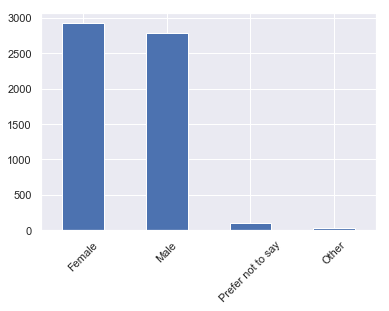

In [8]:
# Check gender distribution
print(survey.gender.value_counts())
survey.gender.value_counts().plot.bar();
plt.xticks(rotation=45);

35 - 54        2019
18-34          1779
55 - 74        1572
Under 18        329
75 or older     139
Name: age, dtype: int64


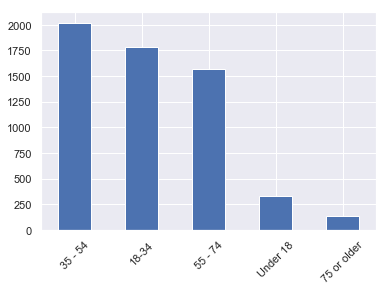

In [9]:
# Check age distribution
print(survey.age.value_counts())
survey.age.value_counts().plot.bar();
plt.xticks(rotation=45);

$0 - $10,000          1829
$26,000 - $75,000     1437
$11,000 - $25,000     1017
$76,000 - $150,000     581
$151,000 or more       318
Name: annual_income, dtype: int64


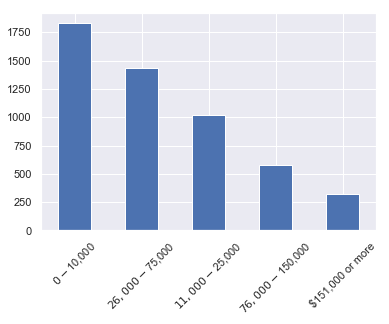

In [10]:
# Check annual_income distribution
print(survey.annual_income.value_counts())
survey.annual_income.value_counts().plot.bar();
plt.xticks(rotation=45);

FR    1006
JP     899
MX     892
RU     684
GB     658
DE     625
US     459
BR     375
CO     314
TW     275
Name: country, dtype: int64


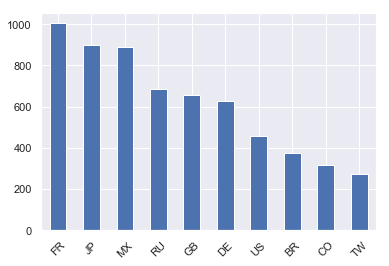

In [11]:
# Check annual_income distribution
print(survey.country.value_counts())
survey.country.value_counts().plot.bar();
plt.xticks(rotation=45);

Android phone or tablet    2594
iPhone or iPad             2496
Web browser                 821
Name: duolingo_platform, dtype: int64


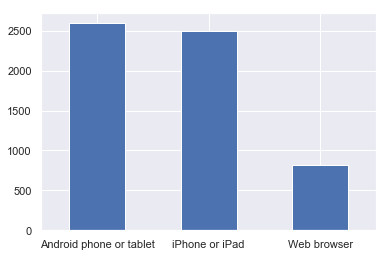

In [12]:
# Check duolingo_platform distribution
print(survey.duolingo_platform.value_counts())
survey.duolingo_platform.value_counts().plot.bar();
plt.xticks(rotation=0);

Daily                     4341
Weekly                    1070
Monthly                    292
Less than once a month     178
I don't use Duolingo        30
Name: duolingo_usage, dtype: int64


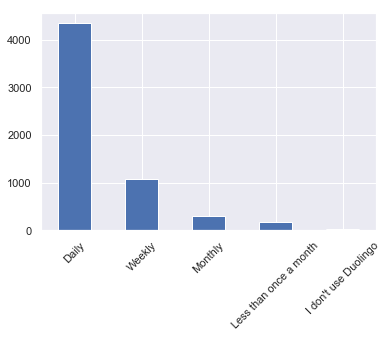

In [13]:
# Check duolingo_usage distribution
print(survey.duolingo_usage.value_counts())
survey.duolingo_usage.value_counts().plot.bar();
plt.xticks(rotation=45);

No, I have never paid for Duolingo Plus             3914
Yes, I currently pay for Duolingo Plus              1622
I don't know if I pay for Duolingo Plus              212
No, but I have previously paid for Duolingo Plus     153
Name: duolingo_subscriber, dtype: int64


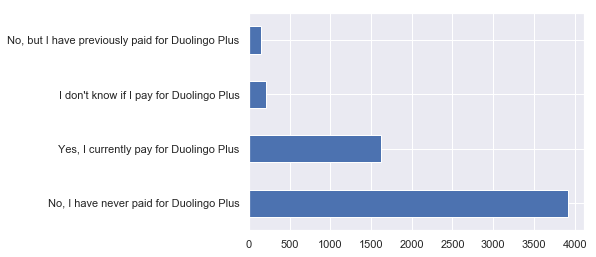

In [14]:
# Check duolingo_subscriber distribution
print(survey.duolingo_subscriber.value_counts())
survey.duolingo_subscriber.value_counts().plot.barh();

Employed full-time    2904
Retired               1043
Unemployed             937
Employed part-time     846
Name: employment_status, dtype: int64


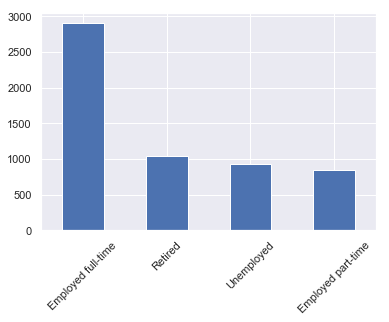

In [15]:
# Check employment_status distribution
print(survey.employment_status.value_counts())
survey.employment_status.value_counts().plot.bar();
plt.xticks(rotation=45);

Not currently a student    4408
Full-time student           752
Part-time student           363
Name: student, dtype: int64


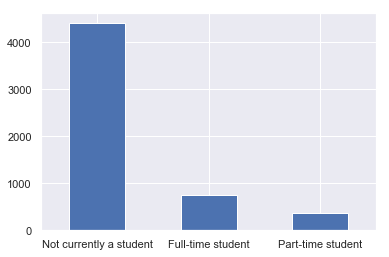

In [16]:
# Check student distribution
print(survey.student.value_counts())
survey.student.value_counts().plot.bar();
plt.xticks(rotation=0);

I'm very committed to learning this language.          2365
I'm moderately committed to learning this language.    2025
I'm extremely committed to learning this language.      867
I'm slightly committed to learning this language.       635
I'm not at all committed to learning this language.     130
Name: primary_language_commitment, dtype: int64


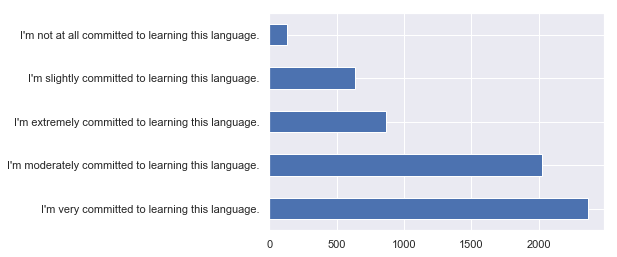

In [17]:
# Check primary_language_commitment distribution
print(survey.primary_language_commitment.value_counts())
survey.primary_language_commitment.value_counts().plot.barh();

In [18]:
# Check primary_language_review distribution
survey.primary_language_review.value_counts()

I am using Duolingo to learn this language for the first time.    3036
I am using Duolingo to review a language I've studied before.     2978
Name: primary_language_review, dtype: int64

In [19]:
# Check motivation distribution
survey.primary_language_motivation.value_counts()

I need to be able to speak the local language where I live            812
I want to use my time more productively                               740
I am preparing for a trip                                             711
I want to keep my brain healthy                                       709
I want to connect with my heritage or identity                        636
I want to improve relationships with some of the people in my life    499
I like to learn new languages                                         455
I want my family to learn a language together                         404
I am interested in a culture that speaks this language                327
I want to advance professionally or economically                      281
I want to challenge myself                                            164
I need to learn this language for school                              152
I don't want to forget what I've previously learned                    58
Name: primary_language_motivation, dty

In [20]:
# Quick check on type of each column
usage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6149 entries, 0 to 6148
Data columns (total 12 columns):
user_id                    6149 non-null object
duolingo_start_date        6149 non-null object
daily_goal                 2687 non-null float64
highest_course_progress    6135 non-null float64
took_placement_test        6135 non-null object
purchased_subscription     6149 non-null bool
highest_crown_count        5857 non-null float64
n_active_days              6149 non-null int64
n_lessons_started          5993 non-null float64
n_lessons_completed        5993 non-null float64
longest_streak             6149 non-null int64
n_days_on_platform         6149 non-null int64
dtypes: bool(1), float64(5), int64(3), object(3)
memory usage: 534.5+ KB


In [21]:
# Unique number of categories in each columns
usage.nunique(axis=0, dropna=True)

user_id                    6149
duolingo_start_date        6126
daily_goal                    7
highest_course_progress      82
took_placement_test           2
purchased_subscription        2
highest_crown_count         439
n_active_days                95
n_lessons_started           958
n_lessons_completed         930
longest_streak              692
n_days_on_platform         1751
dtype: int64

In [22]:
# Quick check on missing percentage
usage.isna().mean().sort_values(ascending=False)

daily_goal                 0.563018
highest_crown_count        0.047487
n_lessons_completed        0.025370
n_lessons_started          0.025370
took_placement_test        0.002277
highest_course_progress    0.002277
n_days_on_platform         0.000000
longest_streak             0.000000
n_active_days              0.000000
purchased_subscription     0.000000
duolingo_start_date        0.000000
user_id                    0.000000
dtype: float64

In [23]:
# Quick check on descriptive statistics for each variable
usage.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
daily_goal,2687.0,25.853740,13.707093,1.0,20.0,20.0,30.0,50.0
highest_course_progress,6135.0,27.846944,19.893642,1.0,11.0,27.0,38.0,83.0
highest_crown_count,5857.0,107.126515,97.168490,0.0,30.0,81.0,160.0,617.0
n_active_days,6149.0,46.921939,34.785790,1.0,12.0,43.0,84.0,95.0
n_lessons_started,5993.0,249.929918,300.918632,1.0,55.0,166.0,332.0,4786.0
n_lessons_completed,5993.0,229.916236,278.934093,0.0,49.0,151.0,306.0,4686.0
longest_streak,6149.0,96.042283,197.216235,0.0,3.0,16.0,83.0,1820.0
n_days_on_platform,6149.0,615.571963,594.823322,2.0,99.0,417.0,1002.0,2402.0


/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


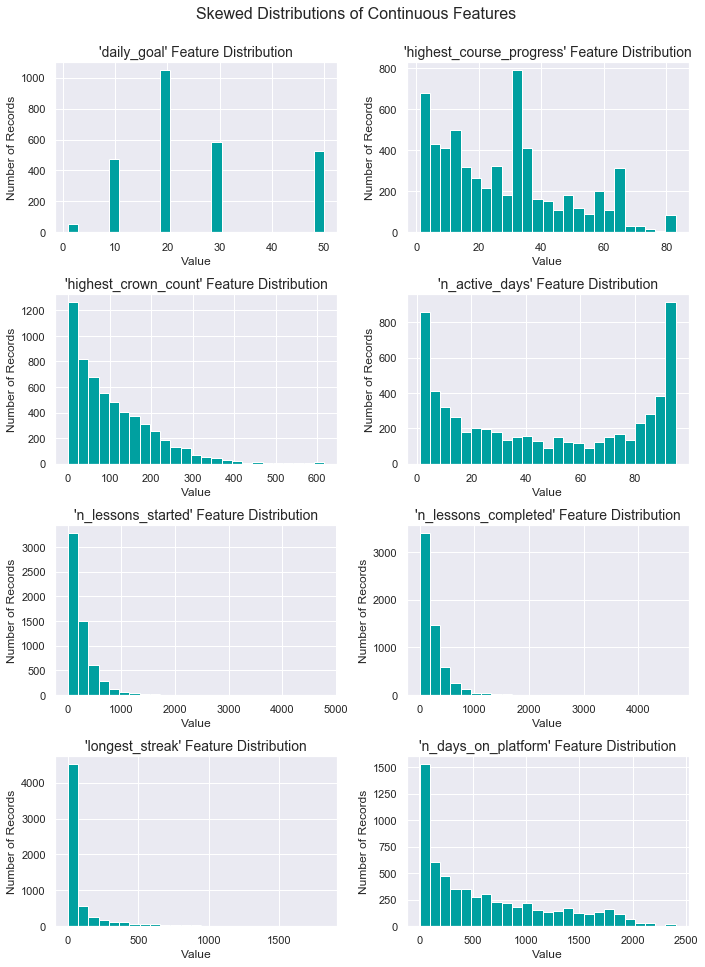

In [24]:
# Check the skewness of numerical variables in data set
num_col = usage.dtypes[(usage.dtypes !='object') & (usage.dtypes !='bool')].index

# Create figure
fig = plt.figure(figsize = (10,13));

# Skewed feature plotting
for i, feature in enumerate(usage[num_col]):
    ax = fig.add_subplot(4, 2, i+1)
    ax.hist(usage[feature], bins = 25, color = '#00A0A0')
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")

# Plot aesthetics
fig.suptitle("Skewed Distributions of Continuous Features", fontsize = 16, y = 1.03)

fig.tight_layout()
fig.show()

## Preparing the Data

### Clean the Data -- Mapping, Aggregration

In [25]:
survey_processed = survey.copy()

# Drop duplicate user_id entries in survey dataset
survey_processed.drop_duplicates(subset='user_id', inplace=True)

In [26]:
# Merge the gender option - 'Prefer not  to say' into 'Other' for easier analysis
survey_processed['gender'] = survey_processed['gender'].apply(lambda x: 'Other' if x=='Prefer not to say' else x)
print(survey_processed.gender.value_counts())

Female    2925
Male      2790
Other      121
Name: gender, dtype: int64


In [27]:
# Shorten the label for easier analysis and more readability
survey_processed['duolingo_subscriber'] = survey_processed.duolingo_subscriber.map({
                                'No, I have never paid for Duolingo Plus': 'Never', 
                                'Yes, I currently pay for Duolingo Plus': 'Current_sub',
                                'I don\'t know if I pay for Duolingo Plus': 'Unknown',
                                'No, but I have previously paid for Duolingo Plus': 'Past_sub'})
print(survey_processed.duolingo_subscriber.value_counts())

Never          3913
Current_sub    1621
Unknown         212
Past_sub        153
Name: duolingo_subscriber, dtype: int64


In [28]:
# For easier analysis, create a shorter lable mapping on primary_language_commitment column
survey_processed['primary_language_commitment'] = survey_processed.primary_language_commitment\
      .map({'I\'m very committed to learning this language.': 'Very committed',
            'I\'m moderately committed to learning this language.': 'Moderately committed',
            'I\'m extremely committed to learning this language.': 'Extremely committed',
            'I\'m slightly committed to learning this language.': 'Slightly committed',
            'I\'m not at all committed to learning this language.': 'Not at all committed',})
print(survey_processed.primary_language_commitment.value_counts())

Very committed          2365
Moderately committed    2025
Extremely committed      865
Slightly committed       635
Not at all committed     130
Name: primary_language_commitment, dtype: int64


In [29]:
# For easier analysis, create a higher level mapping for motivation lable
# Merge similar motivation into big group
survey_processed['primary_language_motivation'] = survey_processed.primary_language_motivation.map({
    'I need to be able to speak the local language where I live': 'Necessary for Life',
    'I want to use my time more productively': 'Productively',
    'I am preparing for a trip': 'Travel',                                             
    'I want to keep my brain healthy': 'Brain Training',                                      
    'I want to connect with my heritage or identity': 'Other',
    'I want to improve relationships with some of the people in my life': 'Relationships',   
    'I like to learn new languages': 'Self-learning',                                      
    'I want my family to learn a language together': 'Relationships',                         
    'I am interested in a culture that speaks this language': 'Culture',            
    'I want to advance professionally or economically': 'Career',                      
    'I want to challenge myself': 'Brain Training',                              
    'I need to learn this language for school': 'School',                 
    'I don\'t want to forget what I\'ve previously learned': 'Self-learning'
})
print(survey_processed.primary_language_motivation.value_counts())

Relationships         902
Brain Training        872
Necessary for Life    812
Productively          740
Travel                711
Other                 636
Self-learning         513
Culture               327
Career                281
School                152
Name: primary_language_motivation, dtype: int64


In [30]:
# Map primary_language_review column to boolean value
survey_processed['primary_language_review'] = survey_processed['primary_language_review']\
.apply(lambda x: False if x == 'I am using Duolingo to learn this language for the first time.' else True)
print(survey_processed.primary_language_review.value_counts())

True     3150
False    3035
Name: primary_language_review, dtype: int64


In [31]:
# Map survey_complete to boolean value
survey_processed['survey_complete'] = survey_processed['survey_complete'].apply(lambda x: True if x==1 else False)
print(survey_processed.survey_complete.value_counts())

True     5727
False     458
Name: survey_complete, dtype: int64


In [32]:
# Map future_contact to boolean value
survey_processed['future_contact'] = survey_processed['future_contact'].map({'Yes':True,
                                                                             'No': False})
print(survey_processed['future_contact'].value_counts())

True     4481
False     963
Name: future_contact, dtype: int64


In [33]:
# Drop primary_language_motivation_followup
survey_processed = survey_processed.drop(['primary_language_motivation_followup','other_resources'], axis=1)
survey_processed.head()

,user_id,age,annual_income,country,duolingo_platform,duolingo_subscriber,duolingo_usage,employment_status,future_contact,gender,primary_language_commitment,primary_language_review,primary_language_motivation,primary_language_proficiency,student,survey_complete,time_spent_seconds
0,35c9fc6e72c911e99681dca9049399ef,18-34,"$26,000 - $75,000",JP,Android phone or tablet,Never,Daily,Employed full-time,True,Male,Very committed,True,Self-learning,Advanced,Not currently a student,True,193
1,35c9fdde72c911e98630dca9049399ef,18-34,"$26,000 - $75,000",JP,iPhone or iPad,Never,Weekly,Employed full-time,True,Male,Slightly committed,True,Necessary for Life,Intermediate,Not currently a student,True,139
2,35c9feb072c911e9ab4cdca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,Current_sub,Daily,Employed full-time,True,Male,Moderately committed,True,Other,Beginner,Not currently a student,True,119
3,35c9ff7072c911e9900ddca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,Past_sub,Daily,Employed full-time,True,Female,Very committed,False,Travel,Intermediate,Not currently a student,True,229
4,35ca002672c911e99effdca9049399ef,35 - 54,"$76,000 - $150,000",JP,Android phone or tablet,Current_sub,Daily,Employed full-time,True,Male,Very committed,False,Other,Intermediate,Not currently a student,True,157


In [34]:
# Based on previous analysis, here join the survey and usage datasets on user_id
# Then will frop the user_id column to make it easier to build model
data = pd.merge(survey_processed, usage, on='user_id', how='left')
data.head()

,user_id,age,annual_income,country,duolingo_platform,duolingo_subscriber,duolingo_usage,employment_status,future_contact,gender,...,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
0,35c9fc6e72c911e99681dca9049399ef,18-34,"$26,000 - $75,000",JP,Android phone or tablet,Never,Daily,Employed full-time,True,Male,...,NaN,58.0,True,False,275.0,91.0,232.0,232.0,589.0,849.0
1,35c9fdde72c911e98630dca9049399ef,18-34,"$26,000 - $75,000",JP,iPhone or iPad,Never,Weekly,Employed full-time,True,Male,...,20.0,4.0,True,False,22.0,54.0,90.0,88.0,27.0,125.0
2,35c9feb072c911e9ab4cdca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,Current_sub,Daily,Employed full-time,True,Male,...,NaN,11.0,False,True,17.0,30.0,49.0,47.0,30.0,479.0
3,35c9ff7072c911e9900ddca9049399ef,18-34,"$76,000 - $150,000",JP,iPhone or iPad,Past_sub,Daily,Employed full-time,True,Female,...,20.0,11.0,False,True,55.0,93.0,1161.0,1028.0,40.0,117.0
4,35ca002672c911e99effdca9049399ef,35 - 54,"$76,000 - $150,000",JP,Android phone or tablet,Current_sub,Daily,Employed full-time,True,Male,...,NaN,64.0,False,True,417.0,85.0,215.0,252.0,266.0,1951.0


### Check Missing Data

In [35]:
# Since NaNs is not accepted by many models, here assess the missing value percentage
# then decide if drop or munipulate
col_missing_cnt = data.isna().sum()
col_missing_pct = (col_missing_cnt[col_missing_cnt>0] * 100.00 / data.shape[0]).sort_values(ascending=False)
col_missing_pct

daily_goal                      56.556184
annual_income                   16.248989
future_contact                  11.980598
student                         10.735651
employment_status                7.388844
gender                           5.642684
age                              5.642684
highest_crown_count              5.303153
duolingo_subscriber              4.624091
duolingo_usage                   4.462409
duolingo_platform                4.462409
primary_language_motivation      3.864188
n_lessons_started                3.104285
n_lessons_completed              3.104285
primary_language_commitment      2.667745
primary_language_proficiency     2.586904
took_placement_test              0.808407
highest_course_progress          0.808407
purchased_subscription           0.582053
duolingo_start_date              0.582053
longest_streak                   0.582053
n_active_days                    0.582053
n_days_on_platform               0.582053
dtype: float64

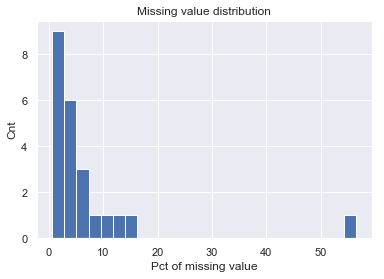

In [36]:
# Investigate patterns in the amount of missing data in each column.
col_missing_pct.sort_values(inplace=True)
plt.hist(col_missing_pct, bins = 25)

plt.xlabel('Pct of missing value')
plt.ylabel('Cnt')
plt.title('Missing value distribution')
plt.grid(True)
plt.show()

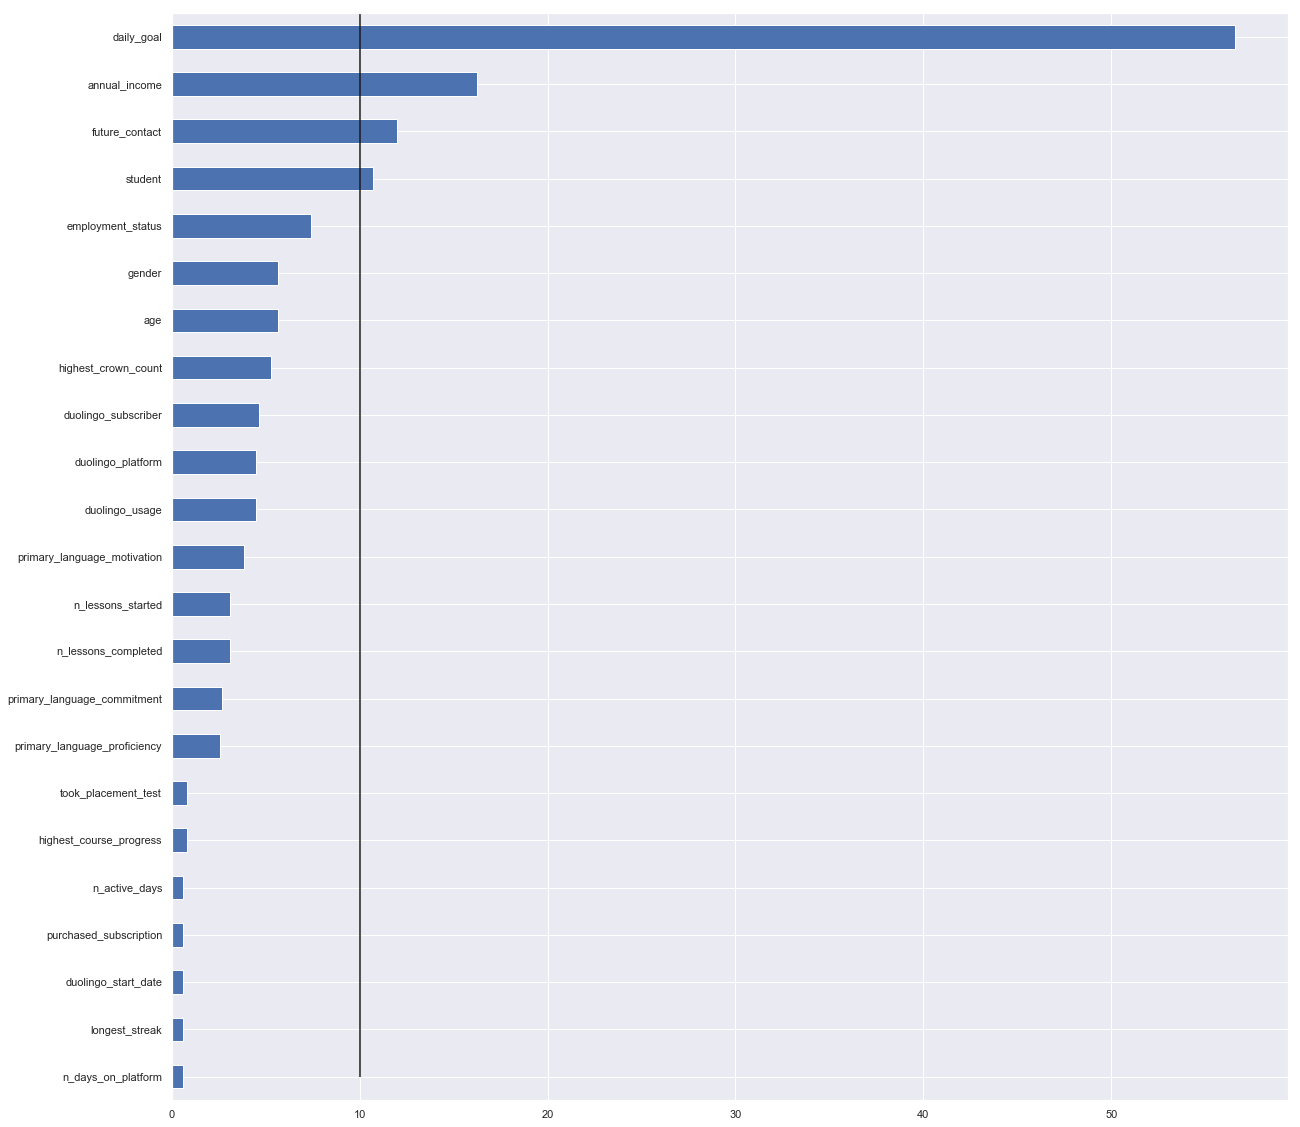

In [37]:
# Explore the detail -- check the name of outlier column
col_missing_pct.plot.barh(figsize=(20,20))
plt.vlines(x=10, ymin=0, ymax=30, colors='k', linestyles='solid')

In [38]:
# Due to lack of data points and importance of some variables (e.g. daily goal, income), couldn't drop all NULL value
# Therefore, here use the most frequent value to imput the categorical features

cat_col = list(data.dtypes[data.dtypes == 'object'].index)

for col in cat_col:
    if data[col].isna().sum() > 0 : 
        most_freq = list(data[col].value_counts().sort_values(ascending=False).index)[0]
        data[col].fillna(most_freq, inplace = True)

In [39]:
# Recheck the missing value percentage after imputing the categorical variables
col_missing_cnt = data.isna().sum()

col_missing_pct = (col_missing_cnt[col_missing_cnt>0] * 100.00 / data.shape[0]).sort_values(ascending=False)
col_missing_pct

daily_goal                 56.556184
highest_crown_count         5.303153
n_lessons_completed         3.104285
n_lessons_started           3.104285
highest_course_progress     0.808407
n_days_on_platform          0.582053
longest_streak              0.582053
n_active_days               0.582053
dtype: float64

In [40]:
# For numeric features, here use mode to replace the NaN value
num_col = data.dtypes[(data.dtypes !='object')].index

for col in num_col:
    if data[col].isna().sum() != 0:
        data[col] = data[col].fillna(data[col].mode()[0])


In [41]:
# Recheck the missing value in data set
print(data.isna().sum())

user_id                         0
age                             0
annual_income                   0
country                         0
duolingo_platform               0
duolingo_subscriber             0
duolingo_usage                  0
employment_status               0
future_contact                  0
gender                          0
primary_language_commitment     0
primary_language_review         0
primary_language_motivation     0
primary_language_proficiency    0
student                         0
survey_complete                 0
time_spent_seconds              0
duolingo_start_date             0
daily_goal                      0
highest_course_progress         0
took_placement_test             0
purchased_subscription          0
highest_crown_count             0
n_active_days                   0
n_lessons_started               0
n_lessons_completed             0
longest_streak                  0
n_days_on_platform              0
dtype: int64


### Transforming Skewed Continuous Features

In [42]:
# Check the skewness of numerical variables in data set
num_col = data.dtypes[(data.dtypes !='object') & (data.dtypes !='bool')].index

# Calculate skew and sort
skew_feats = data[num_col].skew().sort_values(ascending=False)
skewness = pd.DataFrame({'Skew': skew_feats})
skewness

,Skew
time_spent_seconds,10.999599
n_lessons_completed,3.675808
n_lessons_started,3.620138
longest_streak,3.448504
daily_goal,1.799792
highest_crown_count,1.444633
n_days_on_platform,0.895354
highest_course_progress,0.642687
n_active_days,0.080586


In [43]:
# Log transform the skewed features
skewed = list(skewness.index.values)
data_transformed = data.copy()
data_transformed[skewed] = data[skewed].apply(lambda x: np.log(x + 1))

In [44]:
# Recheck the distribution of all numeric variables
data_transformed.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time_spent_seconds,6185.0,5.927616,1.086238,1.098612,5.476464,5.799093,6.163315,13.279265
daily_goal,6185.0,3.085657,0.400778,0.693147,3.044522,3.044522,3.044522,3.931826
highest_course_progress,6185.0,3.045128,0.896392,0.693147,2.484907,3.332205,3.663562,4.430817
highest_crown_count,6185.0,3.916711,1.536569,0.000000,3.178054,4.330733,5.043425,6.426488
n_active_days,6185.0,3.393274,1.179046,0.693147,2.564949,3.806662,4.454347,4.564348
n_lessons_started,6185.0,4.679878,1.576532,0.693147,3.871201,5.062595,5.786897,8.473659
n_lessons_completed,6185.0,4.536150,1.691934,0.000000,3.737670,4.969813,5.703782,8.452548
longest_streak,6185.0,2.977926,1.871373,0.000000,1.386294,2.833213,4.430817,7.507141
n_days_on_platform,6185.0,5.585149,1.656764,1.098612,4.574711,6.023448,6.907755,7.784473


### Normalizing Numerical Features

In [45]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)

data_log_minmax_transform = data_transformed.copy()
data_log_minmax_transform[num_col] = scaler.fit_transform(data_transformed[num_col])

# Drop the user_id and duolingo_start_date
data_log_minmax_transform.drop(['user_id','duolingo_start_date'], axis=1, inplace=True)

# Show an example of a record with scaling applied
display(data_log_minmax_transform.head())

,age,annual_income,country,duolingo_platform,duolingo_subscriber,duolingo_usage,employment_status,future_contact,gender,primary_language_commitment,...,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,n_lessons_started,n_lessons_completed,longest_streak,n_days_on_platform
0,18-34,"$26,000 - $75,000",JP,Android phone or tablet,Never,Daily,Employed full-time,True,Male,Very committed,...,0.726029,0.905481,True,False,0.874568,0.989006,0.611514,0.644899,0.849874,0.844562
1,18-34,"$26,000 - $75,000",JP,iPhone or iPad,Never,Weekly,Employed full-time,True,Male,Slightly committed,...,0.726029,0.245150,True,False,0.487902,0.856113,0.490676,0.531039,0.443871,0.559041
2,18-34,"$76,000 - $150,000",JP,iPhone or iPad,Current_sub,Daily,Employed full-time,True,Male,Moderately committed,...,0.726029,0.479379,False,True,0.449759,0.708008,0.413710,0.457992,0.457429,0.759091
3,18-34,"$76,000 - $150,000",JP,iPhone or iPad,Past_sub,Daily,Employed full-time,True,Female,Very committed,...,0.726029,0.479379,False,True,0.626369,0.994562,0.818038,0.820622,0.494672,0.549230
4,35 - 54,"$76,000 - $150,000",JP,Android phone or tablet,Current_sub,Daily,Employed full-time,True,Male,Very committed,...,0.726029,0.931393,False,True,0.939157,0.971585,0.601777,0.654642,0.744258,0.968910


## Preprocessing the Data

### Encoding the Categorical Data

In [46]:
# One-hot encode the 'features_log_minmax_transform' data using sklearn.OneHotEncoder

# Categorical columns' names
cat_feats = data_log_minmax_transform.dtypes[data_log_minmax_transform.dtypes=='object'].index.tolist()
cat_idx = [data_log_minmax_transform.columns.get_loc(col) for col in cat_feats]

# Create the encoder.
encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Fit and transform the encoder on categorical features
encoded_cat_feats = encoder.fit_transform(data_log_minmax_transform.loc[:,cat_feats])

# Extract one-hot-encoder's feature names
cat_col_name = data_log_minmax_transform.columns.get_values()[cat_idx].tolist()
encoded_cat_feats_name = encoder.get_feature_names(cat_col_name)

# Generate OHE dataframe and concatenate it with the numerical dataframe later
encoded_cat_feats_df = pd.DataFrame(encoded_cat_feats, columns=encoded_cat_feats_name)
encoded_cat_feats_df.head()

,age_18-34,age_35 - 54,age_55 - 74,age_75 or older,age_Under 18,"annual_income_$0 - $10,000","annual_income_$11,000 - $25,000","annual_income_$151,000 or more","annual_income_$26,000 - $75,000","annual_income_$76,000 - $150,000",...,primary_language_motivation_Relationships,primary_language_motivation_School,primary_language_motivation_Self-learning,primary_language_motivation_Travel,primary_language_proficiency_Advanced,primary_language_proficiency_Beginner,primary_language_proficiency_Intermediate,student_Full-time student,student_Not currently a student,student_Part-time student
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [47]:
# Extract the dataframe with only numerical features
num_col = data_log_minmax_transform.dtypes[data_log_minmax_transform.dtypes!='object'].index
num_feats_df = data_log_minmax_transform[num_col].reset_index()

# Concatenate numerical and encoded categorical features together
data_encoded = pd.merge(num_feats_df, encoded_cat_feats_df, left_index=True, right_index=True).drop('index', axis=1)

print("{} total features after one-hot encoding.".format(len(data_encoded.columns)))

# Display several rows of processed dataframe
data_encoded.head()

74 total features after one-hot encoding.


,future_contact,primary_language_review,survey_complete,time_spent_seconds,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,...,primary_language_motivation_Relationships,primary_language_motivation_School,primary_language_motivation_Self-learning,primary_language_motivation_Travel,primary_language_proficiency_Advanced,primary_language_proficiency_Beginner,primary_language_proficiency_Intermediate,student_Full-time student,student_Not currently a student,student_Part-time student
0,True,True,True,0.342284,0.726029,0.905481,True,False,0.874568,0.989006,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,True,True,True,0.315503,0.726029,0.245150,True,False,0.487902,0.856113,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,True,True,True,0.302847,0.726029,0.479379,False,True,0.449759,0.708008,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,True,False,True,0.356259,0.726029,0.479379,False,True,0.626369,0.994562,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,True,False,True,0.325433,0.726029,0.931393,False,True,0.939157,0.971585,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [48]:
scaler2 = StandardScaler()
data_encoded[data_encoded.columns] = scaler2.fit_transform(data_encoded[data_encoded.columns].as_matrix())
data_encoded.head()

/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,future_contact,primary_language_review,survey_complete,time_spent_seconds,daily_goal,highest_course_progress,took_placement_test,purchased_subscription,highest_crown_count,n_active_days,...,primary_language_motivation_Relationships,primary_language_motivation_School,primary_language_motivation_Self-learning,primary_language_motivation_Travel,primary_language_proficiency_Advanced,primary_language_proficiency_Beginner,primary_language_proficiency_Intermediate,student_Full-time student,student_Not currently a student,student_Part-time student
0,0.429432,0.981576,0.282793,-0.607428,-0.102645,1.151832,1.171132,-0.676278,1.108852,0.957220,...,-0.475615,-0.158729,3.325136,-0.360398,4.040412,-1.093434,-0.812652,-0.37204,0.468701,-0.249334
1,0.429432,0.981576,0.282793,-0.907769,-0.102645,-1.601761,1.171132,-0.676278,-0.508458,0.520852,...,-0.475615,-0.158729,-0.300740,-0.360398,-0.247500,-1.093434,1.230540,-0.37204,0.468701,-0.249334
2,0.429432,0.981576,0.282793,-1.049693,-0.102645,-0.625024,-0.853875,1.478682,-0.667997,0.034534,...,-0.475615,-0.158729,-0.300740,-0.360398,-0.247500,0.914550,-0.812652,-0.37204,0.468701,-0.249334
3,0.429432,-1.018769,0.282793,-0.450708,-0.102645,-0.625024,-0.853875,1.478682,0.070709,0.975461,...,-0.475615,-0.158729,-0.300740,2.774710,-0.247500,-1.093434,1.230540,-0.37204,0.468701,-0.249334
4,0.429432,-1.018769,0.282793,-0.796410,-0.102645,1.259884,-0.853875,1.478682,1.379009,0.900015,...,-0.475615,-0.158729,-0.300740,-0.360398,-0.247500,-1.093434,1.230540,-0.37204,0.468701,-0.249334


### Perform Dimensionality Reduction

In [49]:
# Apply PCA to the data
pca = PCA()
model = pca.fit_transform(data_encoded)

In [50]:
# Investigate the variance accounted for by each principal component.

def plot_pc(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT: None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(18, 8))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", \
                    fontsize=12, rotation = 90)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
    plt.yticks(np.arange(0, 1.1, 0.1))
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

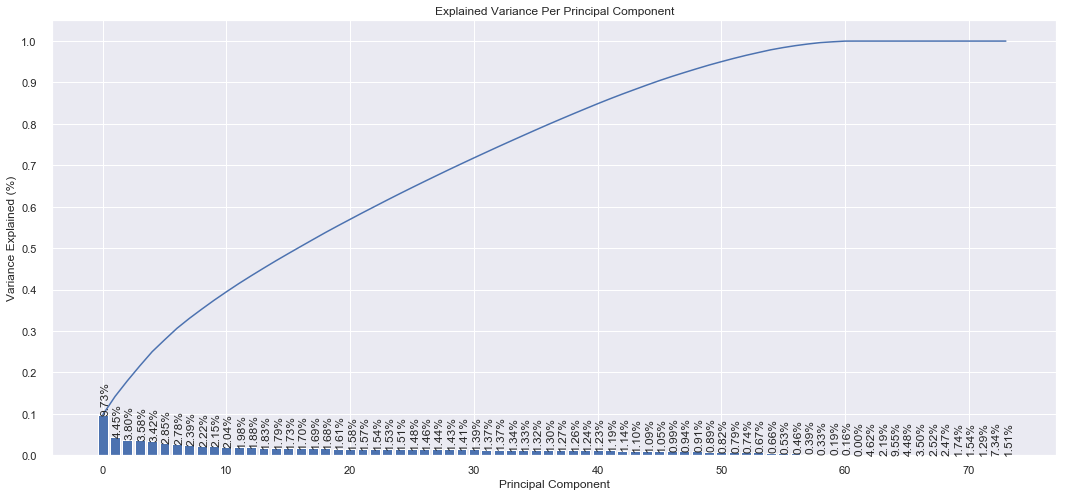

In [51]:
plot_pc(pca)

In [52]:
# Find appropriate number of components to retain
start = time()
for i in np.arange(40, len(pca.explained_variance_ratio_), 3):
    print('For {} components, explained variance:'.format(i), 
          pca.explained_variance_ratio_[:i].sum())
end = time()
print(end - start)

For 40 components, explained variance: 0.8363839308113412
For 43 components, explained variance: 0.8720539512821612
For 46 components, explained variance: 0.9045808066221301
For 49 components, explained variance: 0.9331354242634287
For 52 components, explained variance: 0.9581572160261649
For 55 components, explained variance: 0.9789548699204945
For 58 components, explained variance: 0.9929604504653767
For 61 components, explained variance: 0.9999307364794684
For 64 components, explained variance: 0.9999999999999999
For 67 components, explained variance: 0.9999999999999999
For 70 components, explained variance: 0.9999999999999999
For 73 components, explained variance: 0.9999999999999999
0.0009968280792236328


In [53]:
pca = PCA(n_components=52)
pca_52 = pca.fit_transform(data_encoded)

In [54]:
# Define a function to show the weight of each features by dimension
def show_weight(full_dataset, pca, comp_n, feat_n):
    '''
    Display the weight of each feature in dimension i
    INPUT: 
        full_dataset: dataset
        pca: PCA model fitted with data
        comp_n: index of component
        feat_n: feature number
    OUTPUT: weight of each feature 
    '''
    components = pd.DataFrame(np.round(pca.components_, 4), columns=full_dataset.keys()).iloc[comp_n - 1]
    components.sort_values(ascending=False, inplace=True)
    top2n_components = pd.concat([components.head(feat_n), components.tail(feat_n)])

    # Plot the result
    top2n_components.plot(kind='bar', 
                          title='Top {} weighted features for PCA component {}'.format(feat_n*2, comp_n),
                          figsize=(12, 6))
    plt.show()
#     top_components = pd.concat([components.iloc[:5,:],components.iloc[-5:]]).reset_index()
    return top2n_components

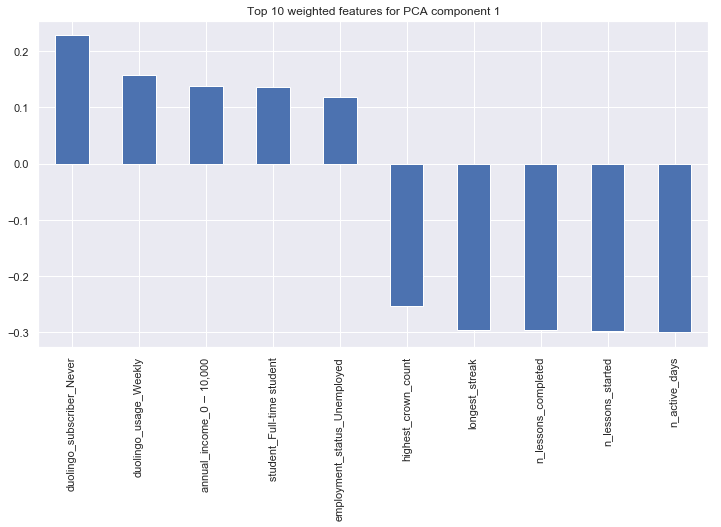

duolingo_subscriber_Never       0.2280
duolingo_usage_Weekly           0.1580
annual_income_$0 - $10,000      0.1380
student_Full-time student       0.1368
employment_status_Unemployed    0.1182
highest_crown_count            -0.2538
longest_streak                 -0.2961
n_lessons_completed            -0.2963
n_lessons_started              -0.2980
n_active_days                  -0.2992
Name: 0, dtype: float64

In [55]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components1 = show_weight(data_encoded, pca, 1, 5)
components1

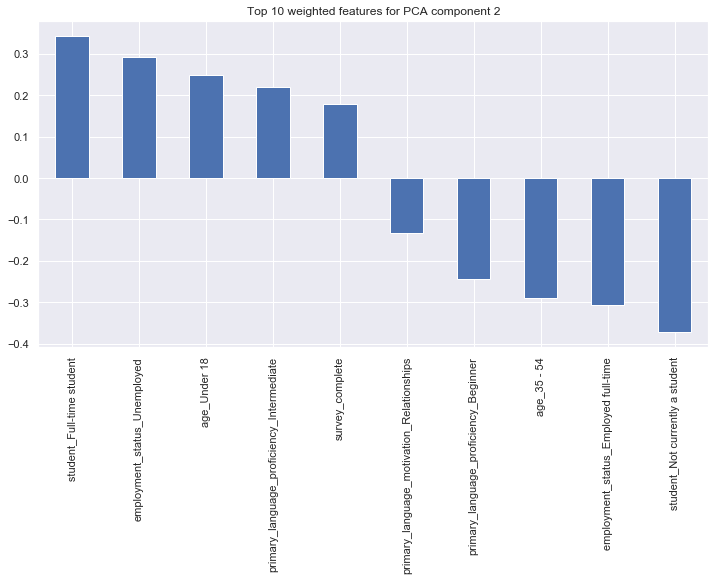

student_Full-time student                    0.3445
employment_status_Unemployed                 0.2936
age_Under 18                                 0.2498
primary_language_proficiency_Intermediate    0.2201
survey_complete                              0.1797
primary_language_motivation_Relationships   -0.1336
primary_language_proficiency_Beginner       -0.2432
age_35 - 54                                 -0.2903
employment_status_Employed full-time        -0.3063
student_Not currently a student             -0.3724
Name: 1, dtype: float64

In [56]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components2 = show_weight(data_encoded, pca, 2, 5)
components2

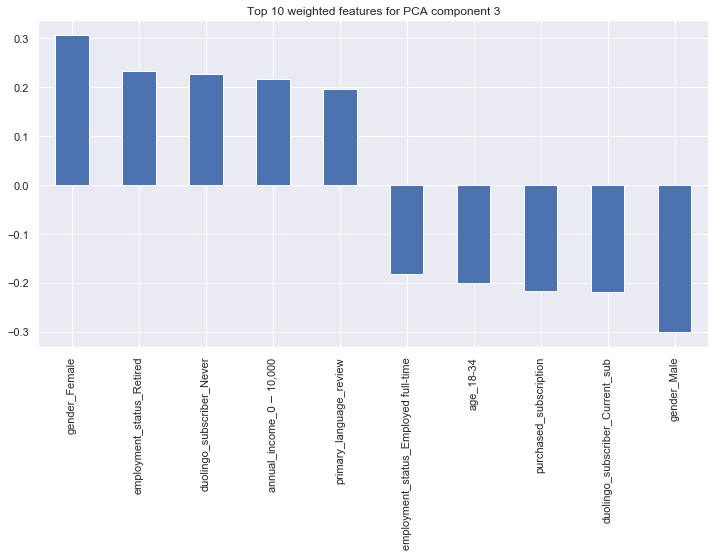

gender_Female                           0.3056
employment_status_Retired               0.2323
duolingo_subscriber_Never               0.2270
annual_income_$0 - $10,000              0.2167
primary_language_review                 0.1966
employment_status_Employed full-time   -0.1819
age_18-34                              -0.2018
purchased_subscription                 -0.2168
duolingo_subscriber_Current_sub        -0.2186
gender_Male                            -0.3004
Name: 2, dtype: float64

In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

components3 = show_weight(data_encoded, pca, 3, 5)
components3

## Apply Clustering

In [58]:
# Investigate the change in within-cluster distance across number of clusters.
def get_kmeans_score(data, center):
    '''
    return the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    # instantiate kmeans
    kmeans = KMeans(n_clusters=center)
    
    # Then fit the model to you data using the fit mothod
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
#     score = np.abs(model.score(data))
    wcss = model.inertia_
#     return score
    return wcss


In [59]:
scores = []
centers = list(range(1, 15))

start = time()

for center in centers:
    print('Fitting k = {} '.format(center))
    scores.append(get_kmeans_score(pca_52, center))
end = time()

print("--- Run time: %s mins ---" % np.round(((end - start)/60),2))

Fitting k = 1 
Fitting k = 2 
Fitting k = 3 
Fitting k = 4 
Fitting k = 5 
Fitting k = 6 
Fitting k = 7 
Fitting k = 8 
Fitting k = 9 
Fitting k = 10 
Fitting k = 11 
Fitting k = 12 
Fitting k = 13 
Fitting k = 14 
--- Run time: 0.13 mins ---


Text(0.5, 1.0, 'WCSS vs. K')

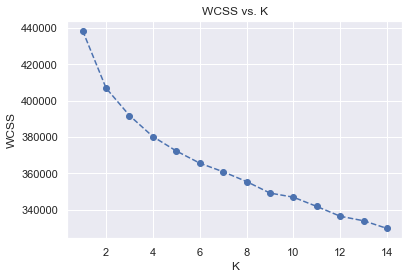

In [60]:
# Plot the SSE value to decide the K value
plt.plot(centers, scores, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('WCSS')
plt.title('WCSS vs. K')


In [61]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters=4)
model = kmeans.fit(pca_52)

In [62]:
# Store the prediction
user_predict = pd.DataFrame(np.array(model.predict(pca_52)), columns=['cluster'])

# Count the cluster number
cluster_cnt = user_predict['cluster'].value_counts().sort_index()
display(cluster_cnt)

cluster_prop = pd.DataFrame((cluster_cnt/cluster_cnt.sum()), columns=['cluster']).reset_index()
cluster_prop.set_index('index', inplace=True)
display(cluster_prop)


0     759
1    1678
2    1532
3    2216
Name: cluster, dtype: int64

,cluster
index,
0,0.122716
1,0.271302
2,0.247696
3,0.358286


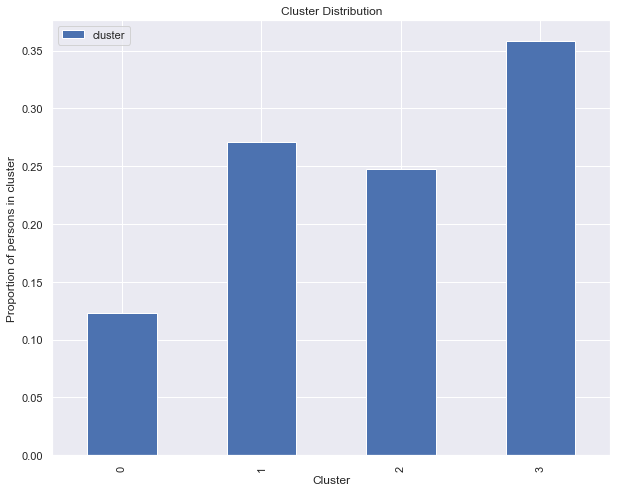

In [63]:
cluster_prop = cluster_prop.reset_index()
cluster_prop.plot(x = 'index', y = 'cluster', kind = 'bar', figsize = (10,8))
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Proportion of persons in cluster')
plt.show()

In [66]:
# Investigate top components of cluster 0
cluster0_components = pd.Series(kmeans.cluster_centers_[0])
cluster0_components.sort_values(ascending=False, inplace=True)
print(cluster0_components.head(5))
print(cluster0_components.tail(5))

1     3.086626
0     3.034662
9     0.358791
47    0.266586
3     0.261286
dtype: float64
29   -0.233948
6    -0.252165
2    -0.659135
7    -0.825013
4    -1.103208
dtype: float64


In [68]:
# To get the detail of cluster, transfer cluster back to analyze the principle component
cluster0 = scaler2.inverse_transform(pca.inverse_transform(pca_52))[user_predict.cluster==0]
cluster0_features = pd.DataFrame(data = np.round(cluster0), columns= data_encoded.columns)
# cluster0_features.head()

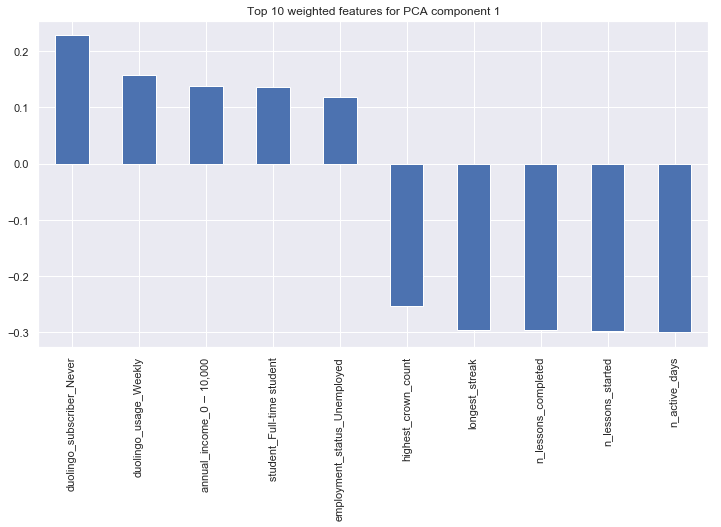

duolingo_subscriber_Never       0.2280
duolingo_usage_Weekly           0.1580
annual_income_$0 - $10,000      0.1380
student_Full-time student       0.1368
employment_status_Unemployed    0.1182
highest_crown_count            -0.2538
longest_streak                 -0.2961
n_lessons_completed            -0.2963
n_lessons_started              -0.2980
n_active_days                  -0.2992
Name: 0, dtype: float64

In [69]:
# Chenck top features in first component
show_weight(cluster0_features, pca, 1, 5)

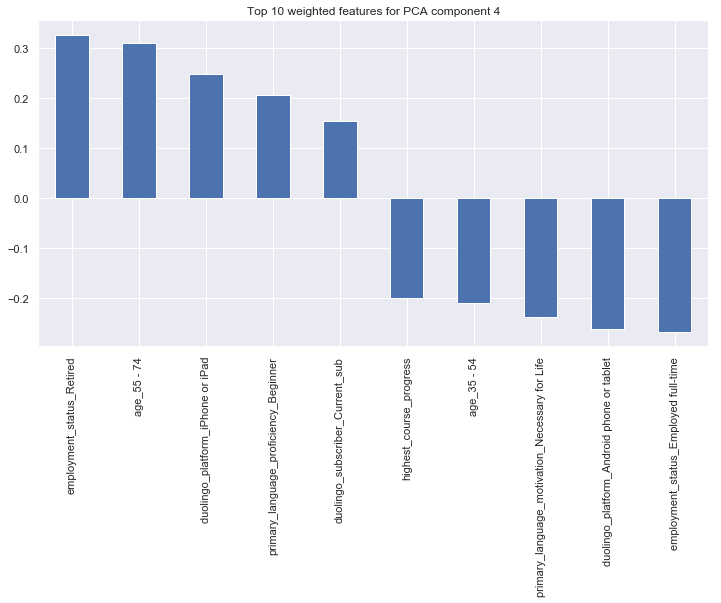

employment_status_Retired                         0.3252
age_55 - 74                                       0.3097
duolingo_platform_iPhone or iPad                  0.2480
primary_language_proficiency_Beginner             0.2060
duolingo_subscriber_Current_sub                   0.1530
highest_course_progress                          -0.1984
age_35 - 54                                      -0.2100
primary_language_motivation_Necessary for Life   -0.2378
duolingo_platform_Android phone or tablet        -0.2611
employment_status_Employed full-time             -0.2662
Name: 3, dtype: float64

In [74]:
# Chenck top features in first component
show_weight(cluster0_features, pca, 4, 5)

In [73]:
# Investigate top components of cluster 1
cluster1_components = pd.Series(kmeans.cluster_centers_[1])
cluster1_components.sort_values(ascending=False, inplace=True)
print(cluster1_components.head(5))
print(cluster1_components.tail(5))

5    0.667412
3    0.623444
6    0.445741
7    0.320397
9    0.289989
dtype: float64
50   -0.130416
47   -0.148107
4    -0.168195
2    -0.992797
0    -3.072860
dtype: float64


In [76]:
# To get the detail of cluster, transfer cluster back to analyze the principle component
cluster1 = scaler2.inverse_transform(pca.inverse_transform(pca_52))[user_predict.cluster==1]
cluster1_features = pd.DataFrame(data = np.round(cluster1), columns= data_encoded.columns)
# cluster1_features.head()

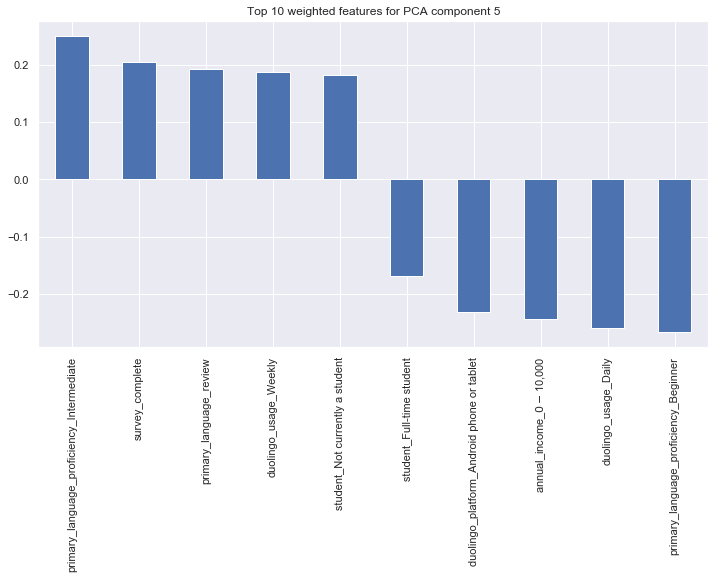

primary_language_proficiency_Intermediate    0.2508
survey_complete                              0.2043
primary_language_review                      0.1937
duolingo_usage_Weekly                        0.1873
student_Not currently a student              0.1832
student_Full-time student                   -0.1697
duolingo_platform_Android phone or tablet   -0.2320
annual_income_$0 - $10,000                  -0.2439
duolingo_usage_Daily                        -0.2607
primary_language_proficiency_Beginner       -0.2675
Name: 4, dtype: float64

In [77]:
# Chenck top features in top component
show_weight(cluster1_features, pca, 5, 5)

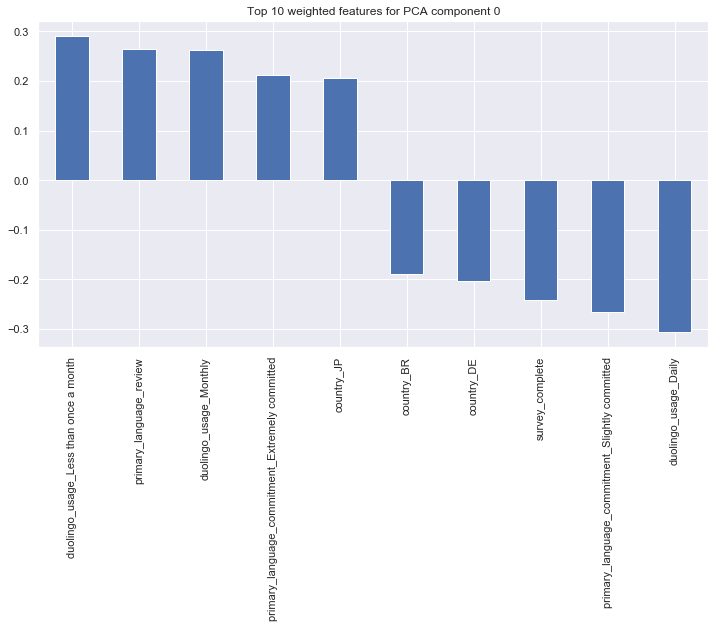

duolingo_usage_Less than once a month              0.2913
primary_language_review                            0.2649
duolingo_usage_Monthly                             0.2631
primary_language_commitment_Extremely committed    0.2113
country_JP                                         0.2051
country_BR                                        -0.1895
country_DE                                        -0.2031
survey_complete                                   -0.2421
primary_language_commitment_Slightly committed    -0.2653
duolingo_usage_Daily                              -0.3063
Name: 51, dtype: float64

In [78]:
# Chenck top features in top component
show_weight(cluster1_features, pca, 0, 5)

## Map the Cluster back to Original Data Set

In [79]:
data_cluster = pd.merge(data, user_predict,left_index=True, right_index=True)

/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


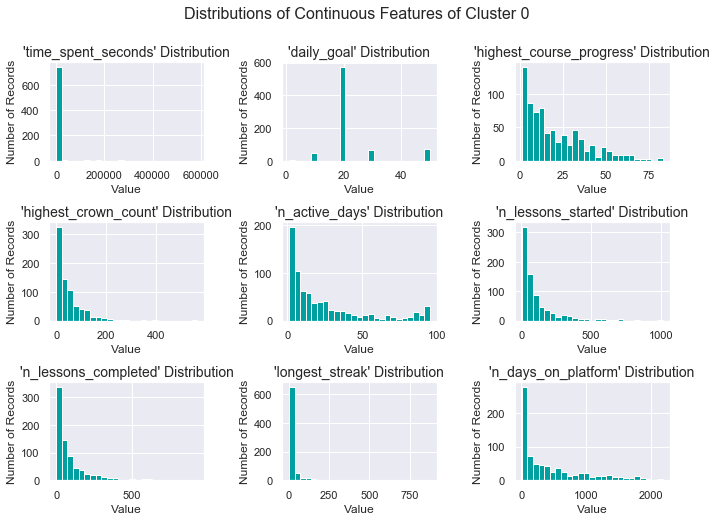

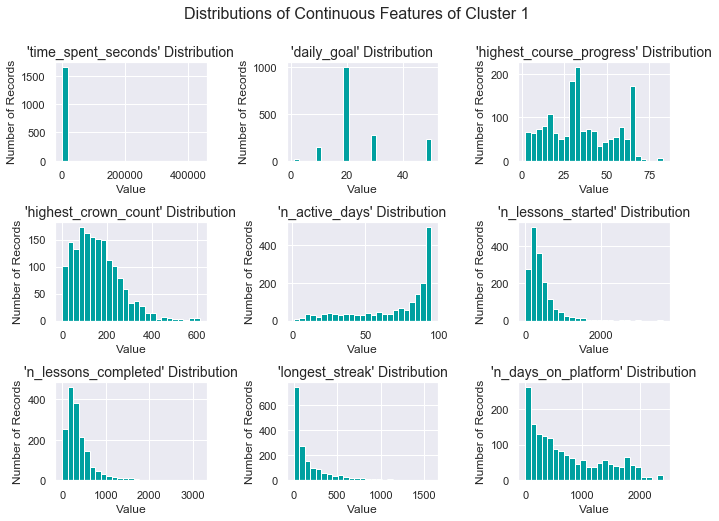

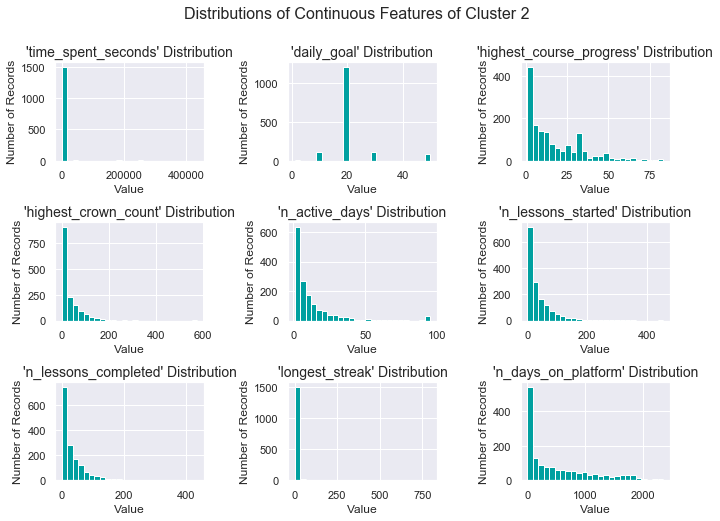

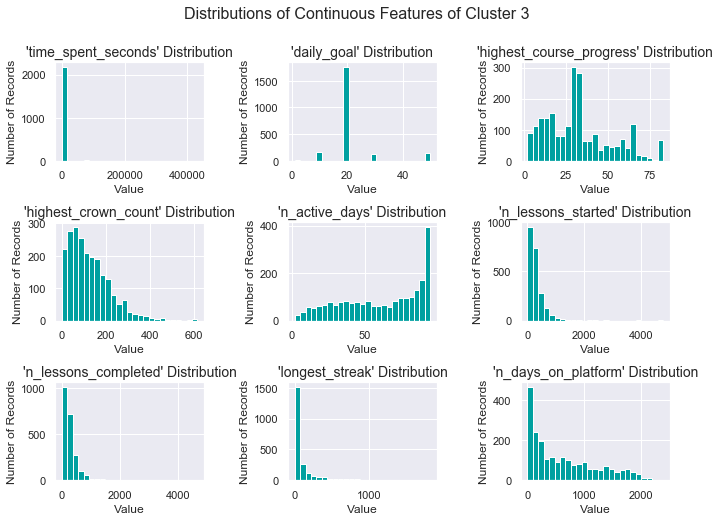

In [80]:
for cl in range(0,4):
    cluster_i = data_cluster[data_cluster.cluster==cl]
#     cluster_i

    # Check the skewness of numerical variables in data set
    num_col = cluster_i.dtypes[(cluster_i.dtypes != 'object') & (cluster_i.dtypes != 'bool')].index

    # Create figure
    fig = plt.figure(figsize = (10,13));

    # Skewed feature plotting
    for i, feature in enumerate(cluster_i[num_col]):
        if feature != 'cluster':
            ax = fig.add_subplot(6, 3, i+1)
            ax.hist(cluster_i[feature], bins = 25, color = '#00A0A0')
            ax.set_title("'%s' Distribution"%(feature), fontsize = 14)
            ax.set_xlabel("Value")
            ax.set_ylabel("Number of Records")
    
    # Plot aesthetics
    title = "Distributions of Continuous Features of Cluster {}".format(cl)
    fig.suptitle(title, fontsize = 16, y = 1.03)

    fig.tight_layout()
    fig.show()

/Users/fanyuan/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


<Figure size 936x1656 with 0 Axes>

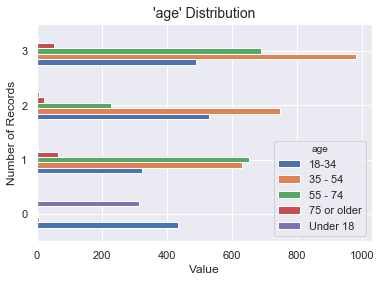

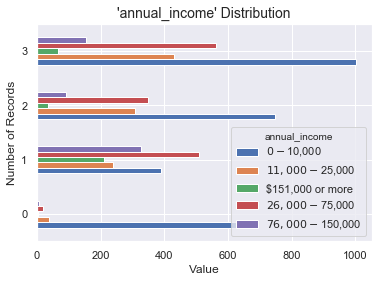

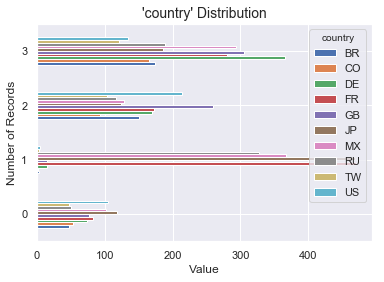

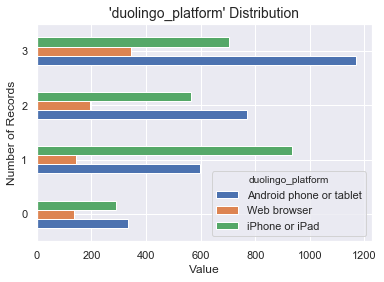

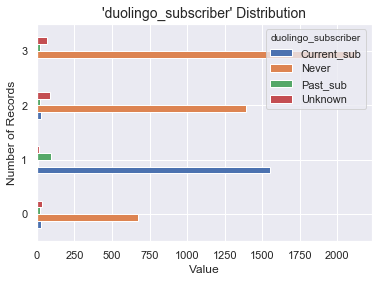

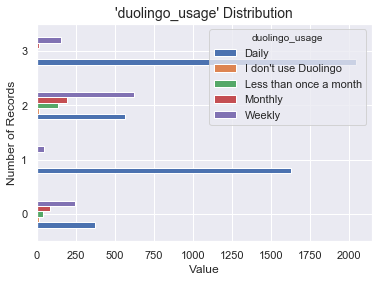

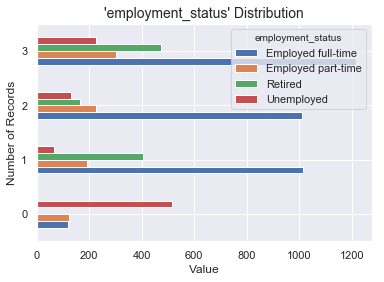

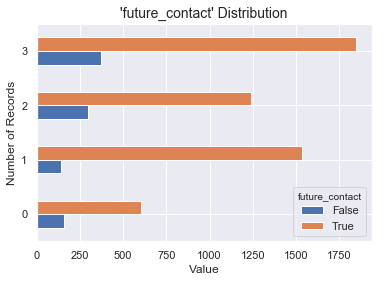

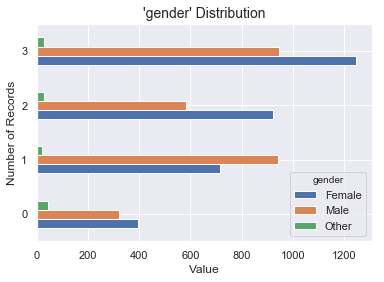

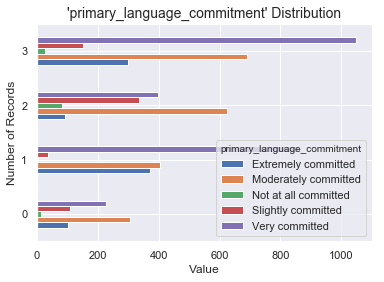

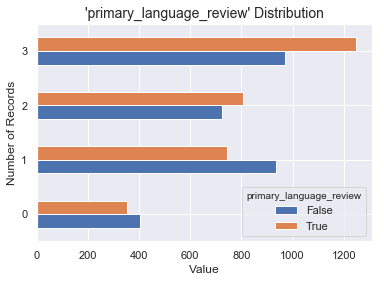

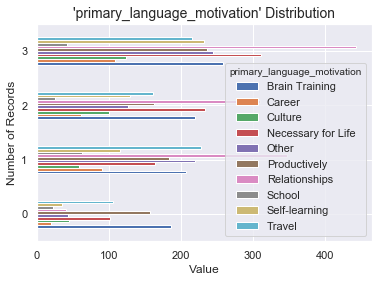

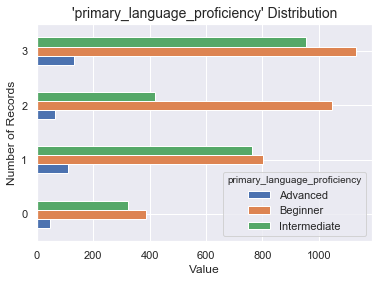

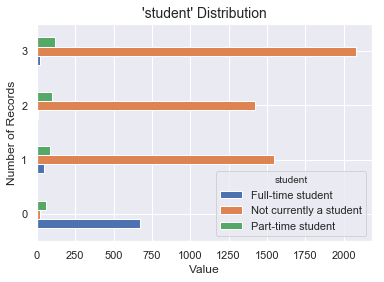

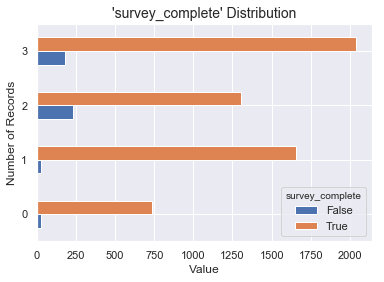

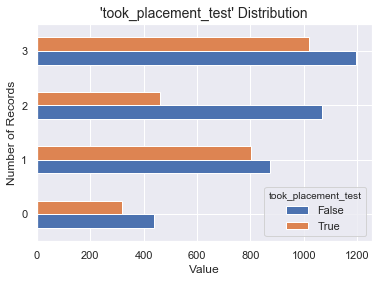

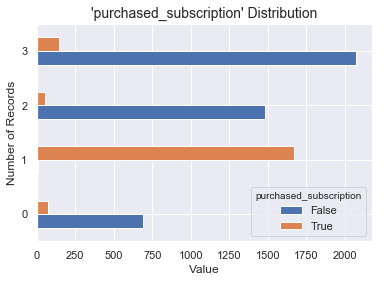

In [83]:
# Check the skewness of numerical variables in data set
cat_col = data_cluster.dtypes[(data_cluster.dtypes == 'object') | (data_cluster.dtypes == 'bool')].index

# Create figure
figure = plt.figure(figsize = (13, 23));
    
# Skewed feature plotting
for i, feature in enumerate(data_cluster[cat_col]):
    if feature not in ['user_id','duolingo_start_date']:
#         ax = figure.add_subplot(10, 2, i+1)
        ax = data_cluster.groupby('cluster')[feature].value_counts().unstack().plot.barh()
        ax.set_title("'%s' Distribution"%(feature), fontsize = 14)
        ax.set_xlabel("Value")
        ax.set_ylabel("Number of Records")
    
# Plot aesthetics
title = "Distributions of Categorical Features of Cluster"
figure.suptitle(title, fontsize = 12, y = 1.03)

figure.tight_layout()
figure.show()